In [26]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import datetime
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', None)

In [27]:
df=pd.read_csv('data.csv', encoding='cp932')
df = df.sample(frac=1, random_state=0)
upside_bool = df["up_side"] > 0
df.loc[upside_bool, "nearest_source_E"] = df["up_side"]
feature = ['processing', 'nearest_source_E', 'nearest_source_dist', 'no_water_days', 'build_count', 'density', 'agri_area']
# feature = ['processing', 'nearest_source_E', 'nearest_source_type', 'nearest_source_dist', 'no_water_days', 'build_count', 'density', 'agri_area']
y=df['Ecoli']
X=df.loc[:, feature]
X = X.fillna(X.mean())

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3,
                                                  random_state=1, stratify=y)
print('Labels counts in y:', np.bincount(y))
print('Lables counts in y_train:', np.bincount(y_train))
print('Lables counts in y_test:', np.bincount(y_test))

Labels counts in y: [ 92 110]
Lables counts in y_train: [64 77]
Lables counts in y_test: [28 33]


In [29]:
processing = X['processing']
# nearest_source_type = X['nearest_source_type']
X=(X-X.mean(axis=0))/X.std(axis=0)
X['processing'] = processing
# X['nearest_source_type'] = nearest_source_type

X_train_std=(X_train-X_train.mean(axis=0))/X_train.std(axis=0)
X_train_std['processing'] = X_train['processing']
# X_train_std['nearest_source_type'] = X_train['nearest_source_type']
X_test_std=(X_test-X_train.mean(axis=0))/X_train.std(axis=0)
X_test_std['processing'] = X_test['processing']
# X_test_std['nearest_source_type'] = X_test['nearest_source_type']

# SVM

In [30]:
# チューニング
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
pipe_svc=make_pipeline( SVC(random_state=1))

param_range=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid=[{'svc__C':param_range, 'svc__kernel':['linear', 'kernel']}]

gs=GridSearchCV(estimator=pipe_svc,
                param_grid=param_grid,
                scoring='accuracy',
                cv=10,
     
                n_jobs=-1)
svm_result=gs.fit(X_train_std, y_train)

print('best', gs.best_params_, gs.best_score_)

best {'svc__C': 0.0001, 'svc__kernel': 'linear'} 0.5461904761904762


In [31]:
max_index = np.argmin(svm_result.cv_results_["rank_test_score"])
for i in range(5):
    max_value = svm_result.cv_results_["split{}_test_score".format(i)][max_index]
    print(max_value)

0.5333333333333333
0.5714285714285714
0.5714285714285714
0.5714285714285714
0.5714285714285714


In [32]:
from sklearn.svm import SVC
svm=SVC(kernel='linear', C=1, random_state=1, probability=True)

svm.fit(X_train_std, y_train)
print('train', svm.score(X_train_std, y_train))
print('test', svm.score(X_test_std, y_test))

train 0.6099290780141844
test 0.5901639344262295


# random forest

In [8]:
# チューニング
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
forest = RandomForestClassifier()

param_grid =[{"n_estimators": [i for i in range(1, 51)],
           "criterion": ["gini", "entropy"],
           "max_depth":[i for i in range(1, 21)]
          }]

gs=GridSearchCV(forest,
                param_grid=param_grid,
                scoring='accuracy',
                cv=5,
                n_jobs=-1)
forest_result=gs.fit(X_train_std, y_train)

print('best', gs.best_params_, gs.best_score_)

best {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 45} 0.6674876847290641


In [9]:
max_index = np.argmin(forest_result.cv_results_["rank_test_score"])
for i in range(5):
    max_value = forest_result.cv_results_["split{}_test_score".format(i)][max_index]
    print(max_value)

0.5517241379310345
0.7142857142857143
0.6785714285714286
0.6785714285714286
0.7142857142857143


In [15]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(criterion='gini', max_depth=2, n_estimators=45)
forest.fit(X_train_std, y_train)

print('train', forest.score(X_train_std, y_train))
print('test', forest.score(X_test_std, y_test))

train 0.7375886524822695
test 0.5737704918032787


# light gbm

In [11]:
model = lgb.LGBMClassifier()
# パラメーターを設定する
param_grid = {"max_depth": [i for i in range(1, 21)], #10, 25,
               "criterion": ["gini", "entropy"],
              "n_estimators": [i for i in range(1, 51)], # 500
             }
# パラメータチューニングをグリッドサーチで行うために設定する
## このGridSearchCV には注意が必要 scoring は そのスコアを基準にして最適化する
gs = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

light_result=gs.fit(X_train_std, y_train)
print('best', gs.best_params_, gs.best_score_)

[LightGBM] [Warning] Unknown parameter: criterion
best {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 18} 0.6889162561576354


In [12]:
max_index = np.argmin(light_result.cv_results_["rank_test_score"])
for i in range(5):
    max_value = light_result.cv_results_["split{}_test_score".format(i)][max_index]
    print(max_value)

0.5517241379310345
0.7142857142857143
0.6785714285714286
0.6785714285714286
0.8214285714285714


In [16]:
light=lgb.LGBMClassifier(criterion='gini', max_depth=1, n_estimators=18)
light.fit(X_train_std, y_train)

print('train', light.score(X_train_std, y_train))
print('test', light.score(X_test_std, y_test))

[LightGBM] [Warning] Unknown parameter: criterion
train 0.6879432624113475
test 0.4918032786885246


# shap

In [17]:
explainer = shap.TreeExplainer(model=forest, feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X=X_test_std)

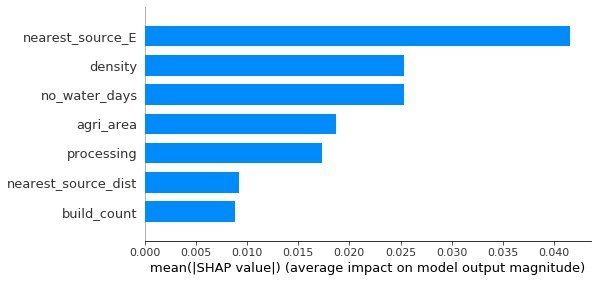

In [18]:
shap.summary_plot(shap_values[1], X_test_std, plot_type="bar")

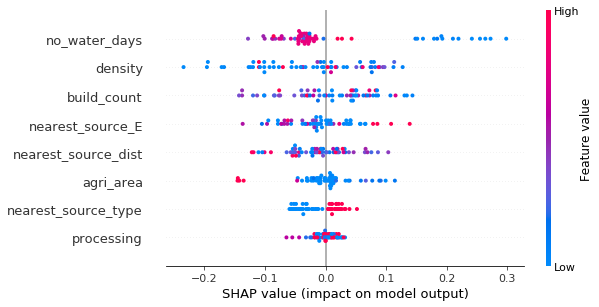

In [61]:
shap.summary_plot(shap_values[1], X_test_std)

# SVM（上流情報なし）

In [ ]:
df=pd.read_csv('data.csv', encoding='cp932')

feature = ['processing', 'nearest_source_E', 'nearest_source_dist', 'no_water_days', 'build_count', 'density', 'agri_area']
y=df['Ecoli']
X=df.loc[:, feature]
X = X.fillna(X.mean())

In [7]:
# チューニング
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
pipe_svc=make_pipeline( SVC(random_state=1))

param_range=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid=[{'svc__C':param_range, 'svc__kernel':['linear', 'kernel']}]

gs=GridSearchCV(estimator=pipe_svc,
                param_grid=param_grid,
                scoring='accuracy',
                cv=5,
     
                n_jobs=-1)
gs=gs.fit(X_train_std, y_train)

print('best', gs.best_params_, gs.best_score_)

best {'svc__C': 1.0, 'svc__kernel': 'linear'} 0.5596059113300493


In [8]:
# チューニング
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
pipe_svc=make_pipeline( SVC(random_state=1))

param_range=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid=[{'svc__C':param_range, 'svc__kernel':['linear', 'kernel']}]

gs=GridSearchCV(estimator=pipe_svc,
                param_grid=param_grid,
                scoring='accuracy',
                cv=5,
     
                n_jobs=-1)
gs=gs.fit(X, y)

print('best', gs.best_params_, gs.best_score_)

best {'svc__C': 1000.0, 'svc__kernel': 'linear'} 0.5493902439024391


In [19]:
from sklearn.svm import SVC
svm=SVC(kernel='linear', C=1, random_state=1, probability=True)

svm.fit(X_train_std, y_train)
print('train', svm.score(X_train_std, y_train))
print('test', svm.score(X_test_std, y_test))

train 0.5886524822695035
test 0.6065573770491803


# random forest

In [10]:
# チューニング
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
forest = RandomForestClassifier()

param_grid =[{"n_estimators": [i for i in range(1, 51)],
           "criterion": ["gini", "entropy"],
           "max_depth":[i for i in range(1, 21)]
          }]

gs=GridSearchCV(forest,
                param_grid=param_grid,
                scoring='accuracy',
                cv=5,
                n_jobs=-1)
gs=gs.fit(X_train_std, y_train)

print('best', gs.best_params_, gs.best_score_)

best {'criterion': 'entropy', 'max_depth': 17, 'n_estimators': 25} 0.7019704433497538


In [11]:
# チューニング
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
forest = RandomForestClassifier()

param_grid =[{"n_estimators": [i for i in range(1, 51)],
           "criterion": ["gini", "entropy"],
           "max_depth":[i for i in range(1, 21)]
          }]

gs=GridSearchCV(forest,
                param_grid=param_grid,
                scoring='accuracy',
                cv=5,
                n_jobs=-1)
gs=gs.fit(X, y)

print('best', gs.best_params_, gs.best_score_)

best {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 48} 0.623780487804878


In [20]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=25)
forest.fit(X_train_std, y_train)

print('train', forest.score(X_train_std, y_train))
print('test', forest.score(X_test_std, y_test))

train 0.9716312056737588
test 0.5737704918032787


# light gbm

In [13]:
model = lgb.LGBMClassifier()
# パラメーターを設定する
param_grid = {"max_depth": [i for i in range(1, 21)], #10, 25,
               "criterion": ["gini", "entropy"],
              "n_estimators": [i for i in range(1, 51)], # 500
             }
# パラメータチューニングをグリッドサーチで行うために設定する
## このGridSearchCV には注意が必要 scoring は そのスコアを基準にして最適化する
gs = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

gs=gs.fit(X_train_std, y_train)
print('best', gs.best_params_, gs.best_score_)

[LightGBM] [Warning] Unknown parameter: criterion
best {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 6} 0.6386699507389162


In [14]:
model = lgb.LGBMClassifier()
# パラメーターを設定する
param_grid = {"max_depth": [i for i in range(1, 21)], #10, 25,
               "criterion": ["gini", "entropy"],
              "n_estimators": [i for i in range(1, 51)], # 500
             }
# パラメータチューニングをグリッドサーチで行うために設定する
## このGridSearchCV には注意が必要 scoring は そのスコアを基準にして最適化する
gs = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

gs=gs.fit(X, y)
print('best', gs.best_params_, gs.best_score_)

best {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 11} 0.5893902439024391


In [21]:
light=lgb.LGBMClassifier(criterion='gini', max_depth=3, n_estimators=6)
light.fit(X_train_std, y_train)

print('train', light.score(X_train_std, y_train))
print('test', light.score(X_test_std, y_test))

[LightGBM] [Warning] Unknown parameter: criterion
train 0.6737588652482269
test 0.5737704918032787


# shap

In [16]:
explainer = shap.TreeExplainer(model=forest, feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X=X_test_std)

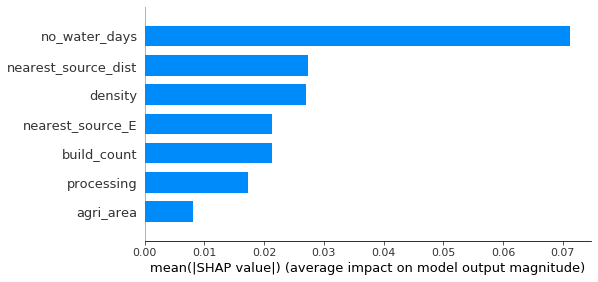

In [17]:
shap.summary_plot(shap_values[1], X_test_std, plot_type="bar")

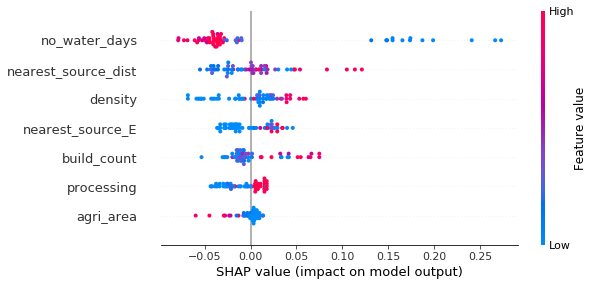

In [18]:
shap.summary_plot(shap_values[1], X_test_std)